# Detect structure in quasicrystal patterns

To show complex graphics, you may need to strat Jupyter with this command

    jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [1]:
%matplotlib inline

from numpy import *
from matplotlib.pylab import *
import scipy
import scipy.spatial
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
from neurotools.plot import *
import neurotools.plot
from neurotools.nlab import *
plt.set_cmap('viridis')

Error, cannot find typedecorator module
FFTW LIBRARY MISSING, USING NUMPY
PLEASE INSTALL FFTW USING
> sudo apt-get install python-fftw
OR
> sudo pip install fftw
statsmodels is missing!
Importing sklearn failed, ROC and AUC will be missing
Loading nlab namespace
statsmodels is not installed! no GLMfit
TRY
 > sudo easy_install statsmodels
AND RESTART PYTHON INTERPRETER
statsmodels import failed! no GLM support. Try:
> pip install -U statsmodels
then restart the python interpreter
On OSX I used
> sudo port install py27-statsmodels
sklearn import failed? no ROC curve analysis. Try:
> pip install -U scikit-learn
then restart the python interpreter
On OSX I used
> sudo port install py27-scikits*
Could not locate the spectrum module, please install it
Multitaper methods will not work
Could not locate the spectrum module, please install it
Multitaper methods will not work
The nitime module is missing. To install, run one of these
> sudo easy_install nitime
> sudo pip install nitime
h5py missi

# Render quasicrystal as sum of plane waves

In [103]:
K  = 60  # frequency of waves. Higher = more
N  = 1000 # size of domain for rasterizing
M  = 5    # number of waves

# Generate grid
x  = linspace(-1,1,N)
y  = linspace(-1,1,N)
xy = x[:,None] + 1j*y[None,:]

(1+0j)
(0.809016994375+0.587785252292j)
(0.309016994375+0.951056516295j)
(-0.309016994375+0.951056516295j)
(-0.809016994375+0.587785252292j)


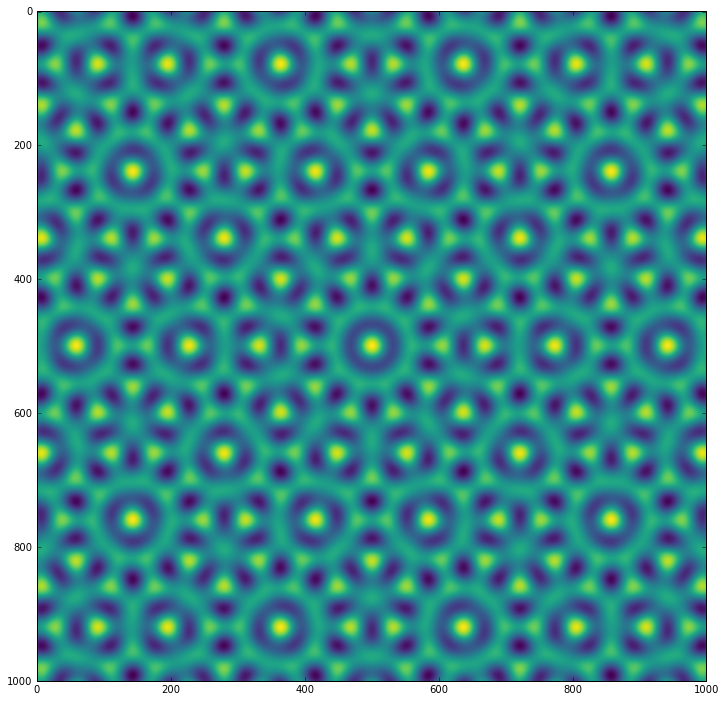

In [104]:
phases = ones(M)*pi*0
rotation = exp(linspace(0,pi,M+1)[:M]*1j)
xyr = array(xy)*0
for p,rr in zip(phases,rotation):
    print(rr)
    xyr += cos(real(xy*rr)*K+p)
qq = xyr#-xyr**2
qq = real(qq)
imshow(qq)

# Detect local maxima

## Approach 1: derivatives

Local maxima should have zero derivative in all directions. They should also have positive scalar curvature.

In [105]:
# Derivative kernel using imaginary part for dy
dkern = complex128([
    [ -0.5-.5j ,-1j, 0.5-0.5j],
    [ -1       ,  0,        1],
    [ -0.5+0.5j, 1j, 0.5+0.5j]
])

lkern = neurotools.spatial.kernels.laplace_kernel()

In [106]:
from scipy.signal import convolve2d

dq = convolve2d(qq,dkern)#*exp(1j*pi/8)
lq = convolve2d(qq,lkern)

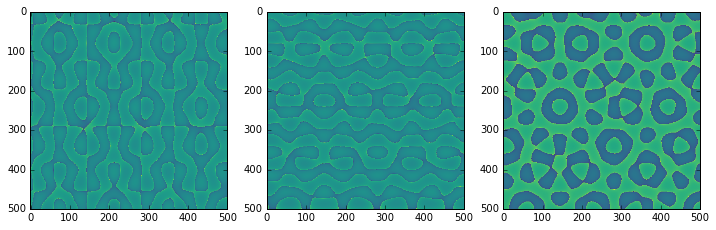

In [108]:
def imlog(x,**kwargs):
    x = float64(x)
    x = log(1e-6+abs(x))*sign(x)
    imshow(x,**kwargs)
subplot(131)
imlog(real(dq)[:N//2,:N//2])
subplot(132)
imlog(imag(dq)[:N//2,:N//2])
subplot(133)
imlog(lq[:N//2,:N//2])

In [109]:
dx,dy = real(dq),imag(dq)
sx,sy = sign(dx),sign(dy)
dxdx_zeros = float32(sx[2:,1:-1]!=sx[:-2,1:-1])
dxdy_zeros = float32(sx[1:-1,2:]!=sx[1:-1,:-2])
dydy_zeros = float32(sy[1:-1,2:]!=sy[1:-1,:-2])
dydx_zeros = float32(sy[2:,1:-1]!=sy[:-2,1:-1])

In [116]:
dxdx = float32(dx[2:,1:-1]-dx[:-2,1:-1])
dxdy = float32(dx[1:-1,2:]-dx[1:-1,:-2])
dydy = float32(dy[1:-1,2:]-dy[1:-1,:-2])
dydx = float32(dy[2:,1:-1]-dy[:-2,1:-1])

The eigenvalues of a $2\times2$ matrix can be expressed in terms of the trace and determinant. 

$\lambda_\pm = \frac{1}{2}\left(\textrm{tr} \pm \sqrt{\textrm{tr}^2-4\det}\right)$


/Users/mrule/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


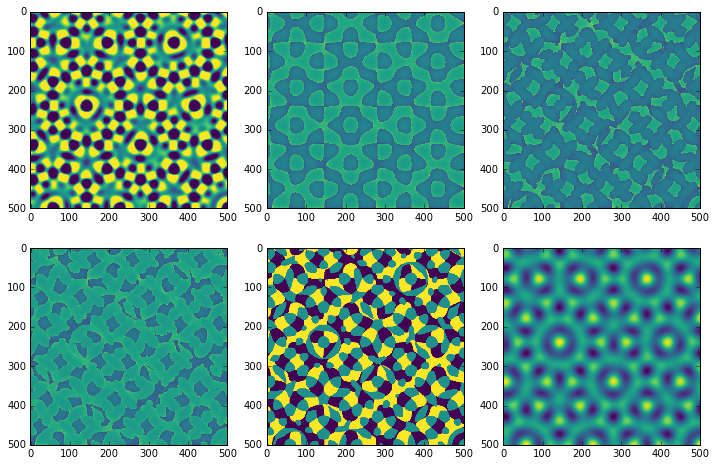

In [139]:
#subplot(311)
det = dxdx*dydy-dxdy*dydx
tr  = dxdx+dydy
l1  = 0.5*(tr+sqrt(complex128(tr**2-4*det)))
l2  = 0.5*(tr-sqrt(complex128(tr**2-4*det)))
subplot(331)
imshow((det)[:N//2,:N//2],vmin=-.01,vmax=.01)
subplot(332)
imlog((tr)[:N//2,:N//2])
subplot(333)
imlog((l1)[:N//2,:N//2])
subplot(334)
imlog((l2)[:N//2,:N//2])
subplot(335)
imlog((sign(l2)+sign(l1))[:N//2,:N//2])
subplot(336)
imshow((qq)[:N//2,:N//2])


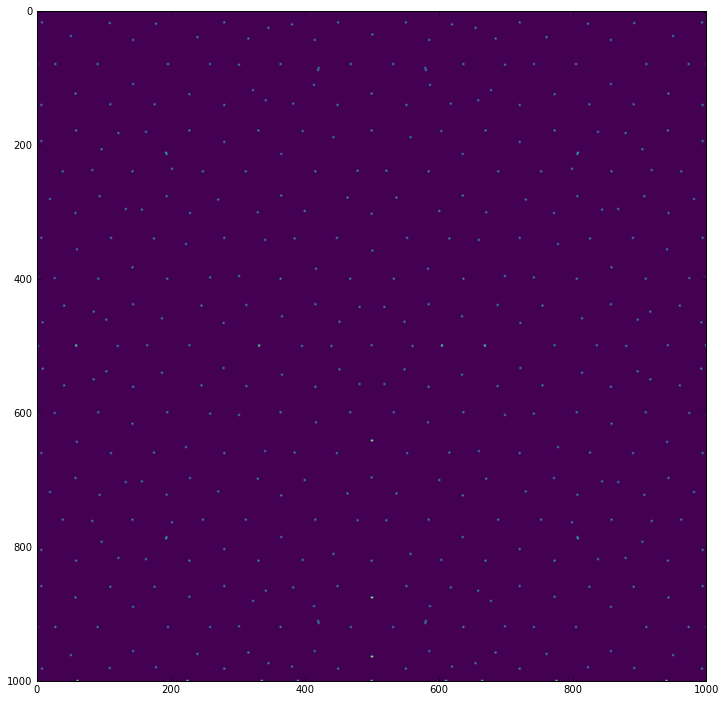

In [163]:
from scipy.ndimage.filters import maximum_filter

peaks = float32(maximum_filter(qq,3)==qq)
imshow(scipy.ndimage.gaussian_filter(peaks,1))

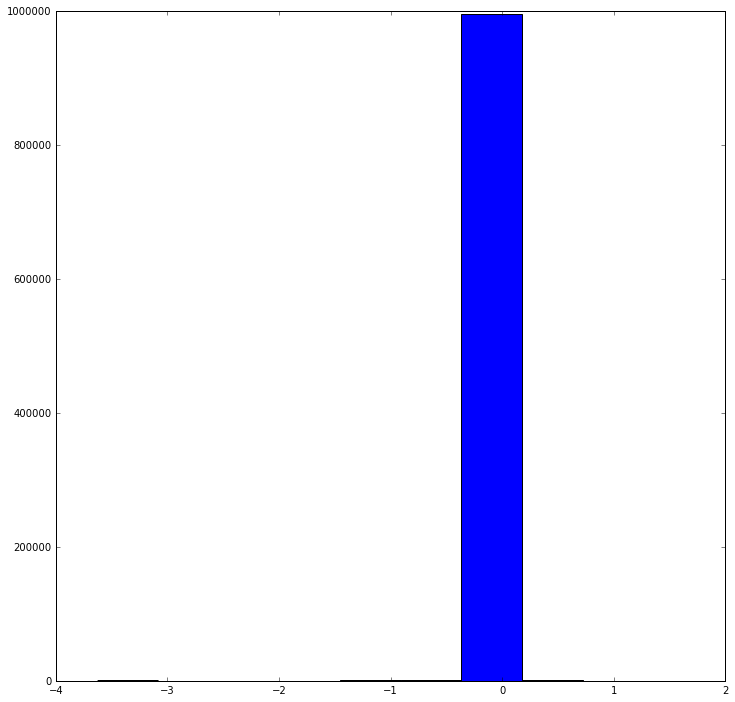

In [118]:
hist(ravel(det));

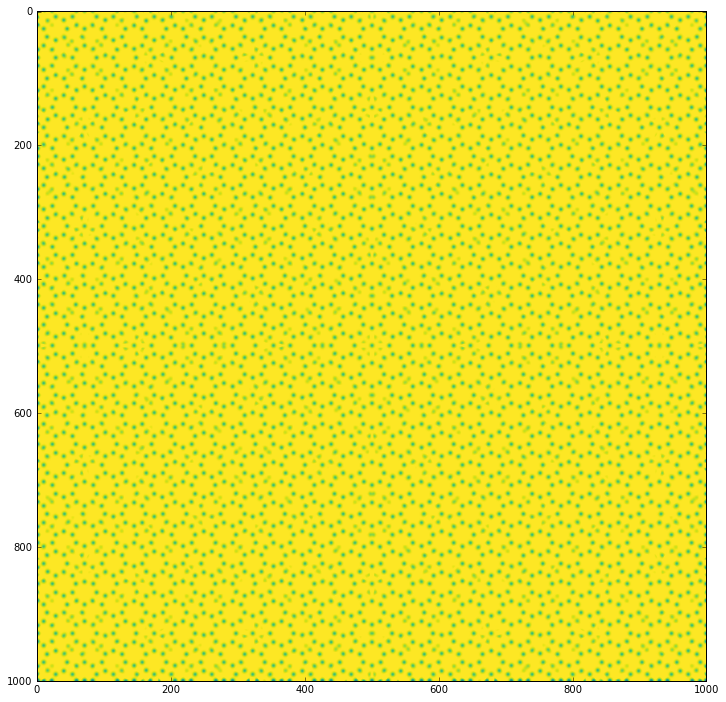

In [100]:
fdet = scipy.ndimage.gaussian_filter(det,2)
fdet[fdet>0]=0
imshow(fdet)

In [ ]:
blur1d = exp(-0.5*linspace(-6,6,5)**2)

In [ ]:
plot(blur1d)

In [ ]:
subplot(131)
imlog(((1+dy_zeros)*(1+dx_zeros))[:200,:200],cmap="gray")

subplot(133)
imlog((dy_zeros*dx_zeros)[:200,:200],cmap="gray")

subplot(132)
imlog(convolve2d(abs(dq),lkern),cmap="gray")


In [ ]:
# expected size of local maxima in pixels
radius = 4
rr = radius**2
d  = radius+1
count = zeros(shape(qq[d:-d,d:-d]))
norm  = 0
for i in arange(-radius,radius+1):
    for j in arange(-radius,radius+1):
        if i*i+j*j>rr: continue
        count += qq[d+i:i-d,d+j:j-d]>qq[d:-d,d:-d]
        norm+=1
count /= norm
imshow(count)

In [ ]:
from collections import defaultdict

def z2xy(z):
    '''
    Converts an array of complex numbers into two arrays
    representing real and imaginary parts, respectively.
    '''
    return real(z),imag(z)

def uniquerow(x):
    '''
    Removes duplicate rows from a 2D numpy array
    '''
    return array(list(set(map(tuple,x))))

def trianglesToEdges(triangles):
    '''
    Accepts Ntriangles x 3 array of triangle indeces, like the format
    returned by `scipy.spatial.Delaunay(...).simplices`. Returns a
    Nedges x 2 numpy array of unique edges in the triangulation
    '''
    tedges    = triangles[:,[0,1,1,2,2,0]].reshape((size(triangles),2))
    tedges    = uniquerow(sort(tedges,axis=1))
    return tedges

def edgesNearby(iz,microd):
    '''
    Returns a dictionary mapping from 
    indecies into point list iz 
    (2d locations passed as x+iy complex)
    to a list of nearby point indices
    
    Computed by thresholding delaunay triangulation
    '''
    points    = array([real(iz),imag(iz)])
    triangles = scipy.spatial.Delaunay(points.T).simplices
    tedges    = trianglesToEdges(triangles)
    edgelen   = ravel(abs(diff(iz[tedges],axis=1)))
    tedges    = tedges[edgelen<microd,:]
    
    #tedges = concatenate([tedges,tedges[:,[1,0]]])
    #coordsparse = scipy.sparse.coo_matrix((ones(tedges.shape[0]),(tedges[:,0],tedges[:,1])))
    #edgelist = scipy.sparse.csr_matrix(coordsparse)
    
    edgelist  = defaultdict(set)
    for i,z in enumerate(iz):
        edgelist[i] = tuple(ravel(tedges[(tedges==i)[:,[1,0]]]))   
    
    return edgelist

def coalesce(iz,edgelist):
    '''
    Joint connected components as defined in edgelist, and return the centroids
    taken as an average of all point locations in list iz 
    (2d locations passed as x+iy complex)
    '''
    components = {}
    for i in arange(len(iz)):
        components[i]=i
        for e in edgelist[i]:
        #for e in scipy.sparse.find(edgelist[i])[1]:
            if e in components:
                components[i]=components[e]
                break
    componentlist = defaultdict(set)
    for e,cid in components.items():
        componentlist[cid]|={e}
    component_ids = sorted(list(set(components.values())))
    centroids = array([mean(iz[array(list(componentlist[cid]))]) for cid in component_ids])
    return centroids

def plot_edges(iz,edges,**kwargs):
    '''
    Plots a set of edges given by 2d complex numbers and Nedges x 2 array of edge indices
    keword arguments are forwarded to matplotlib.plot
    '''
    edgelist = ravel(np.concatenate([edges[:,:1]*NaN,iz[edges]],axis=1))
    plot(*z2xy(array(edgelist)),**kwargs)
    force_aspect()
    
def plot_triangles(iz,triangles,**kwargs):
    '''
    '''
    edges = trianglesToEdges(triangles)
    edgelist = ravel(np.concatenate([edges[:,:1]*NaN,iz[edges]],axis=1))
    plot(*z2xy(array(edgelist)),**kwargs)
    force_aspect()

In [ ]:
thr = 2e-6
iz = xy[d:-d,d:-d][count<thr]
selected = count<thr
iz = xy[selected]

In [ ]:
microd = 18.0/K/M
rotation  = exp(linspace(-pi,pi,2*M+1)[:2*M]*1j)
centroids = coalesce(iz,edgesNearby(iz,microd))
'''centroids = np.concatenate([centroids,conj(centroids)])
centroids = coalesce(centroids,edgesNearby(centroids,microd))
centroids = ravel(centroids[:,None]*rotation[None,:])
centroids = coalesce(centroids,edgesNearby(centroids,microd))'''

In [ ]:
centroids = array(centroids)
points = array([real(centroids),imag(centroids)])
scatter(*points,s=10,color='b')
xlim(-1,1)
ylim(-1,1)
force_aspect()

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
points = array([real(centroids),imag(centroids)])
vor = Voronoi(points.T,qhull_options="Qc")
vor.regions
vor.point_region
v = vor.vertices
v = v[:,0]+1j*v[:,1]
ok = array([(all(array(i)>=0)) for i in vor.regions])
r  = array( vor.regions)[ok]
nc = array([mean(v[rr]) for rr in r])

In [ ]:
figure(figsize=(14,14))

ee = concatenate([array(list(zip(array(e)[arange(-1,len(e))],e))) for e in r])
vmask = array(v)
inbounds = abs(v)>1
vmask[inbounds] = NaN
plot_edges(vmask,ee,color=BLACK,lw=1)
degree = array(list(map(len,r)))

'''for c,reg in zip(nc,r):
    if abs(c)<1:
        text(real(c),imag(c),str(len(reg)),horizontalalignment='center',
          verticalalignment='center')
'''
colors = GATHER[1:-1] + [neurotools.plot.CHARTREUSE, neurotools.plot.CRIMSON, 
                         neurotools.plot.INDEGO, neurotools.plot.MAUVE, 
                         neurotools.plot.MOSS, neurotools.plot.VERIDIAN]
inbounds = abs(nc)<1
for i in range(2,M*2+1):
    scatter(*z2xy(nc[inbounds][degree[inbounds]==i].T),s=100,color=colors[i%len(colors)])
xlim(-1,1)
ylim(-1,1)
force_aspect()

show()